 # Autoregressive Integrated Moving Average (ARIMAS) Model on 5 Years Of Texas Instruments (TXN) Stock Price
### By Heidi Nguyen, Ghizlane Zerouali, and Lauren Darr

## Introduction 
Time series analysis and forecasting have a wide variety of applications. Time series analysis can be used for predicting future values, to describe patterns, explain how the past effects the future, and serve as a control standard for a variable. However, time series require special analyses types because time series data do not meet the assumptions of normal regression problems. Time series data are not independent, they are dependent on time and often show seasonal trends. 

Autoregressive Integrated Moving Average (ARIMA) is a forecasting model designed for short term predictions with univariate data. The ARIMA model requires stationarity. Stationarity means there must be no trends or seasonal patterns. This requirement is challenging for most data sets. For example, stock prices may show seasonality due to the effect of seasons on a business's sales.

In this case, we will use 5 years of Texas Instruments (TXN) stock price data to explore the application of the ARIMA model. 

In [22]:
### Case Study 4 ###
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime

%matplotlib inline
# %pwd 


In [ ]:
# pulling 4 years of Texas Instruments - TXN data 
start_dt=datetime(2014, 1, 1)
end_dt=datetime(2018, 1, 1)

txn = web.DataReader('TXN', 'iex',start_dt, end_dt)['close']
txn.index = pd.to_datetime(txn.index)
txn.tail() 

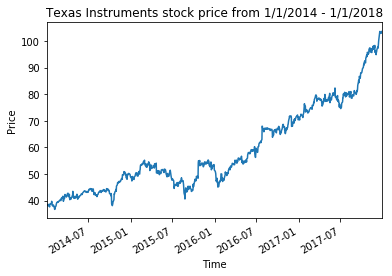

In [24]:
%matplotlib inline
fig = plt.figure()
txn.plot()
plt.title("Texas Instruments stock price from 1/1/2014 - 1/1/2018")
plt.xlabel("Time")
plt.ylabel('Price')
plt.show()

### Texas Instruments stock price plot
This plot of the TXN stock prices from 2014 until 2017 shows that this time series is not strictly stationary. There is an obvious trend upward and some seasonality. In order to confirm the degree of non-stationarity, the Dickey-Fuller test is performed below.


In [25]:
# This is just a function that implements the Dickey-Fuller test 
# and plots data along with rolling mean and standard deviation

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std() 

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


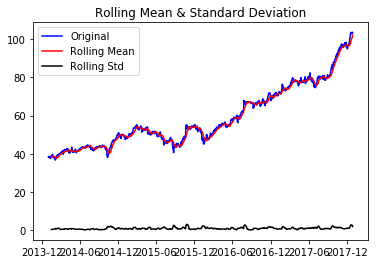

Results of Dickey-Fuller Test:
Test Statistic                    1.267481
p-value                           0.996421
#Lags Used                        0.000000
Number of Observations Used    1006.000000
Critical Value (1%)              -3.436867
Critical Value (5%)              -2.864417
Critical Value (10%)             -2.568302
dtype: float64


In [26]:
test_stationarity(txn) # Perform Dickey-Fuller test

### Stationarity test
The Dickey-Fuller test is a unit root test. Simply put, the null hypothesis is that of non-stationarity, while the alternative hypothesis is that of stationarity. The above output shows the critical value for multiple confidence levels. If we would like to know with 95% confidence that the univariate data shows stationarity, the test statistic must be smaller than the critical value -2.864417. In the case of the TXN stock price data the test statistic is 1.267481 and the p-value is 0.996421. This suggests we cannot reject the null hypothesis and must assume that the data does not have stationarity.


### Make model stationary
In order to fulfill the stationarity requirements, the rolling mean of the stock prices can be subtracted from the individual stock prices in order to remove the upward trend of the data. 


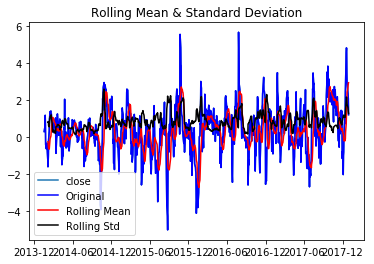

Results of Dickey-Fuller Test:
Test Statistic                -5.952103e+00
p-value                        2.135168e-07
#Lags Used                     1.600000e+01
Number of Observations Used    9.790000e+02
Critical Value (1%)           -3.437047e+00
Critical Value (5%)           -2.864497e+00
Critical Value (10%)          -2.568344e+00
dtype: float64


In [27]:
# get rid of the mean
moving_avg = txn.rolling(12).mean() 
no_trend = txn - moving_avg
plt.plot(no_trend) 
plt.title("Price Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

### Test stationarity again
After the removal of the mean from the individual prices, the model passes the Dickey-Fuller test at a critical value of 0.01. However, by looking at the graph, it is still clear that there is a trend of increasing variance. The ARIMA model assumes that variance is constant. A log transformation will be used on the data in order to improve the variance.

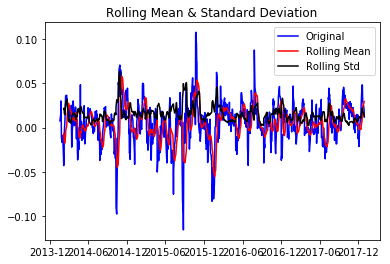

Results of Dickey-Fuller Test:
Test Statistic                -6.105184e+00
p-value                        9.622779e-08
#Lags Used                     1.500000e+01
Number of Observations Used    9.800000e+02
Critical Value (1%)           -3.437040e+00
Critical Value (5%)           -2.864494e+00
Critical Value (10%)          -2.568343e+00
dtype: float64


In [28]:
import numpy as np
log_txn=np.log(txn)
log_moving_avg = log_txn.rolling(12).mean()
log_no_trend=log_txn - log_moving_avg
test_stationarity(log_no_trend.dropna())

### Test stationarity- #3
A third Dickey-Fuller test indicates that the log transformation improves the stationarity of the model a little more beyond subtracting the rolling mean. The graph now shows no apparent upward trend in the variance.


### This next set of charts simply shows all the pieces of the function. 
### Note that while it does include seasonality, there still seems to be residual seasonality in the residuals.


In [ ]:
txn_Prices = txn['#Open']

### Differencing to Remove seasonality and make the series further staionary
Seasonal variation, or seasonality, are cycles that repeat regularly over time. It can result in a changing variance over time, which define a time series as being non-stationary. Stationary datasets are those that have a stable mean and variance, and are in turn much easier to model. Differencing is a popular and widely used data transform for making time series data stationary.
Next we will try some differencing to try to make the series further stationary. This determines if we use a difference term or not. In this example, 1 shift (yt−yt−1yt−yt−1) is used, so d=1

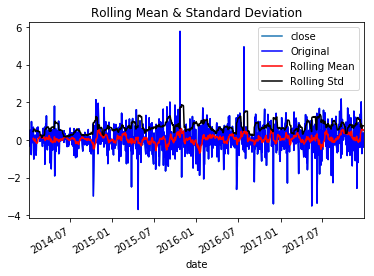

Results of Dickey-Fuller Test:
Test Statistic                  -32.846090
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1005.000000
Critical Value (1%)              -3.436873
Critical Value (5%)              -2.864420
Critical Value (10%)             -2.568304
dtype: float64


In [29]:
diff_txn = txn - txn.shift()
diff_txn.dropna(inplace=True)
diff_txn.plot()
test_stationarity(diff_txn) 

Differencing is applied with d=1, which means the first value was sacrificed. After this method,, the results of Dickey-Fuller test are better than the results in the previous tets. But the plot shows that the data still in increasing pattern and the time series data is not stationary yet.
To make the time series data stationary, the next paragraph will use the log differencing for d=1 to remove the increasing pattern.

### Log Differencing

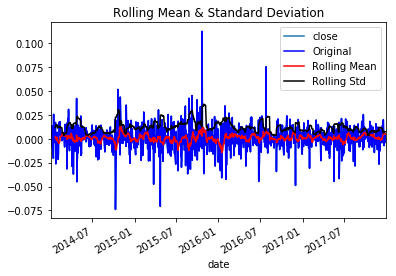

Results of Dickey-Fuller Test:
Test Statistic                  -32.342300
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1005.000000
Critical Value (1%)              -3.436873
Critical Value (5%)              -2.864420
Critical Value (10%)             -2.568304
dtype: float64


In [30]:
diff_txn = log_txn - log_txn.shift()
diff_txn.dropna(inplace=True)
diff_txn.plot()
test_stationarity(diff_txn)

Normally with log transform it should be much better than with no log differencing and the Results of Dickey-Fuller test should show test statistics smaller than critical values and the increasing pattern should be removed. But in this above case there is no difference in the results between log differencing and Differencing to Remove Seasonality, which means that the results above atr the best results that can be found for making the tim series data stationary. 

### Autocorrelation and Partial Autocorrelation plots

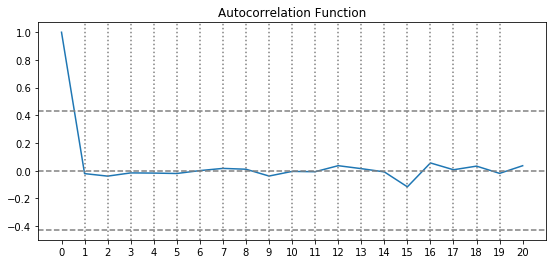

In [31]:
# a look at the Autocorrelation and Partial Autocorrelation plots with log differencing
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(diff_txn.dropna(), nlags=20)
 
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')


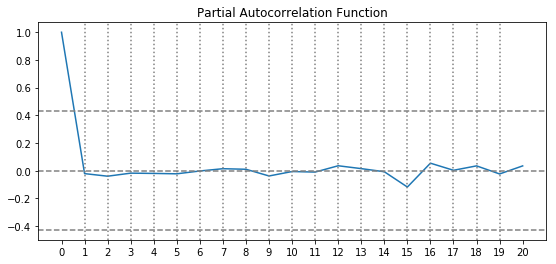

In [32]:
pacf_air_plot = pacf(diff_txn.dropna(), nlags=20) # with diff_txn
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Autocorrelation and partial autocorrelation plots are graphically summarize the strength of a relationship between prices and times in TXN data set. The two plots of the differenced series of autocorrelation and partial autocorrelation show that there is a high correlation between the time and prices of the TXN and have a significant spike only at d=1. And, the plots help to identify the numbers of AR and/or MA terms that are needed.

### ARIMA model

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1006
Model:                     ARMA(1, 0)   Log Likelihood                2905.437
Method:                       css-mle   S.D. of innovations              0.013
Date:                Mon, 04 Jun 2018   AIC                          -5804.874
Time:                        09:06:51   BIC                          -5790.132
Sample:                    01-03-2014   HQIC                         -5799.273
                         - 12-29-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.000      2.363      0.018       0.000       0.002
ar.L1.close    -0.0210      0.032     -0.667      0.505      -0.083       0.041
                                    Roots       

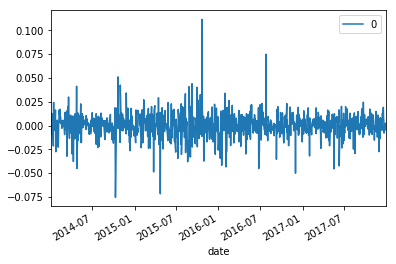

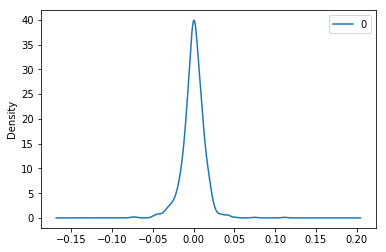

                  0
count  1.006000e+03
mean   7.643630e-08
std    1.347998e-02
min   -7.536013e-02
25%   -6.132378e-03
50%    4.415025e-04
75%    7.310756e-03
max    1.114581e-01


In [33]:
# Now we fit a model of the proper order and look at the output
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(diff_txn.dropna(), order=(1,0,0)) # 1,0,1
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. However, the analysis summary report shows that the model nonetheless performs quite well in the validation period, the AR coefficient is significantly different from zero, and the standard deviation of the residuals is reduced to 1.34e-02 and a mean of 7.64e-08 by the addition of the AR terms. On the whole, this appears to be a good model.

In [ ]:
# Now we fit a model of the proper order and look at the output
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(diff_txn.dropna(), order=(0,1,1)) # 1,0,1
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

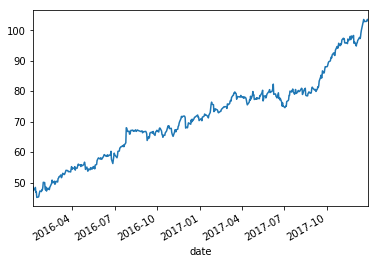

In [34]:
txn[-500:].plot()

0.427433228057


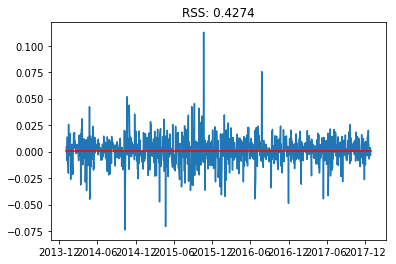

0 0 0
0.427330593215


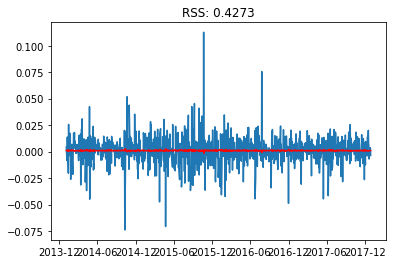

0 0 1
0.426975322928


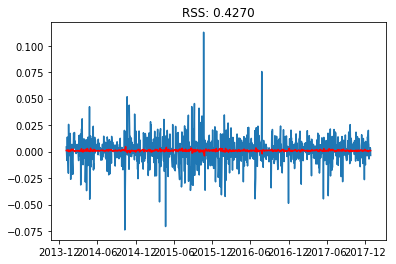

0 0 2


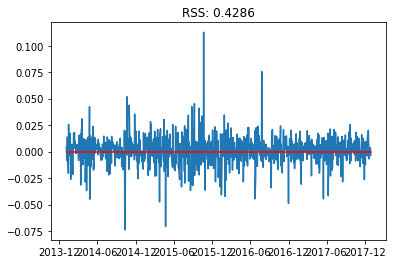

0 1 0


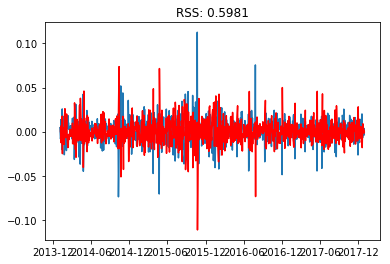

0 1 1


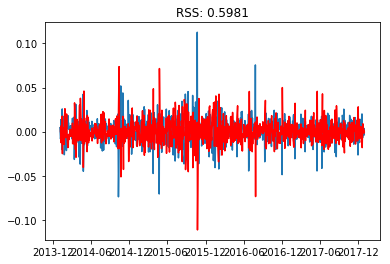

0 1 2


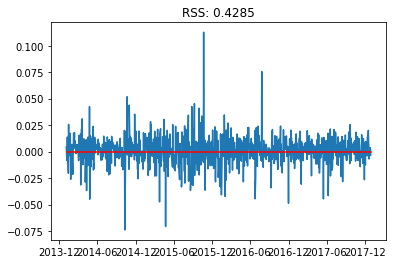

0 2 0


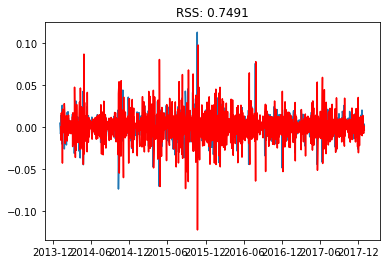

0 2 1


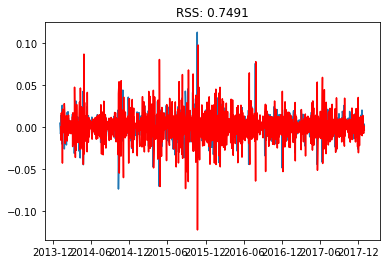

0 2 2


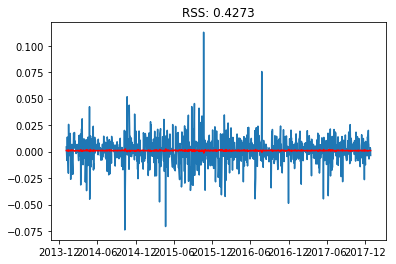

1 0 0


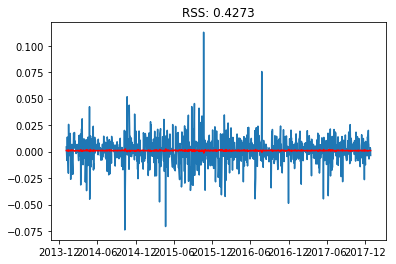

1 0 1


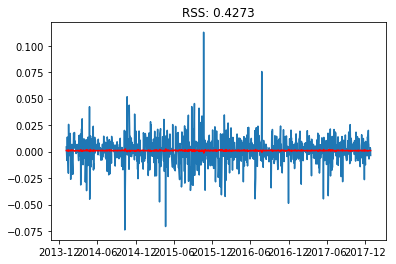

1 0 2


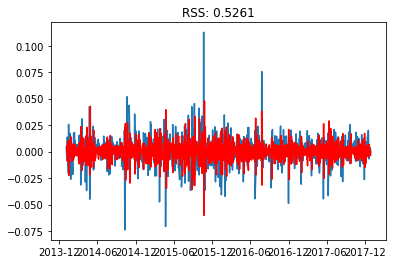

1 1 0


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


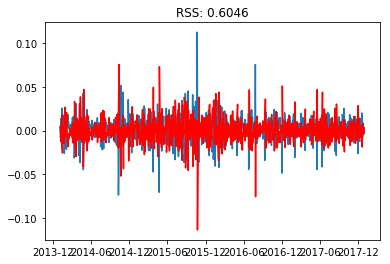

1 1 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


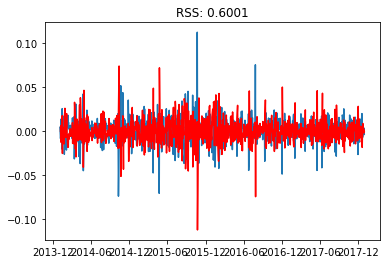

1 1 2


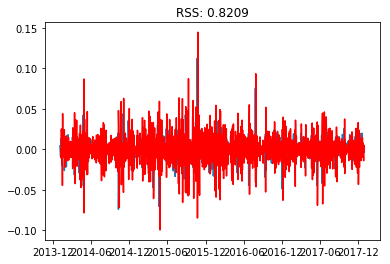

1 2 0


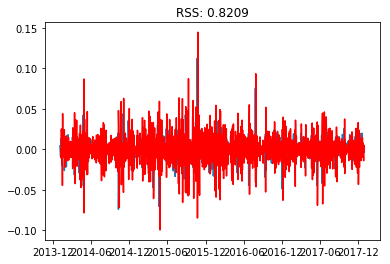

1 2 1


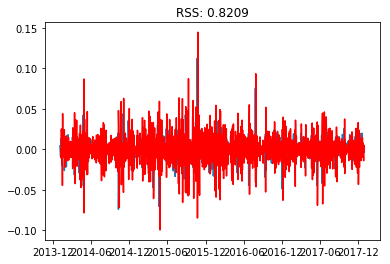

1 2 2


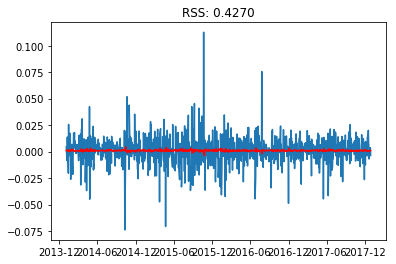

2 0 0
0.426810857318


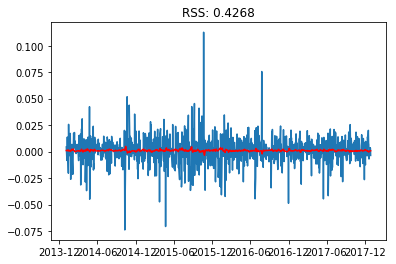

2 0 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.426587249109


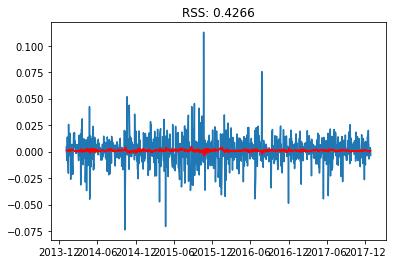

2 0 2


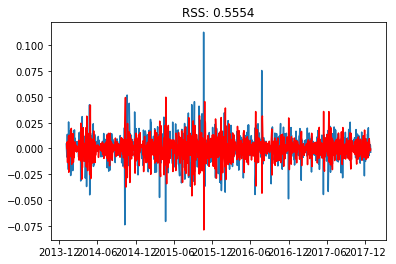

2 1 0


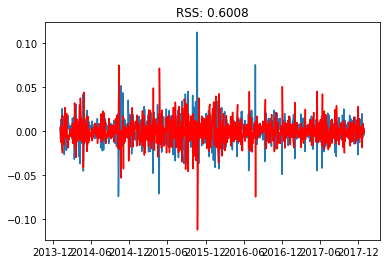

2 1 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


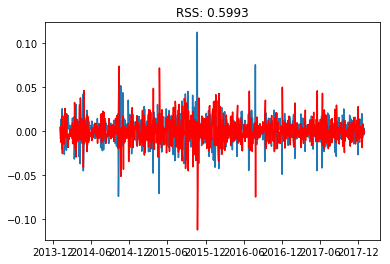

2 1 2


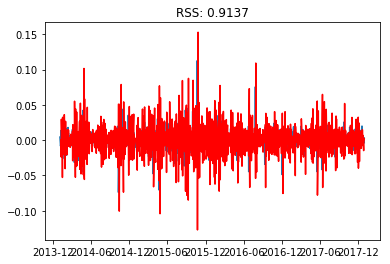

2 2 0


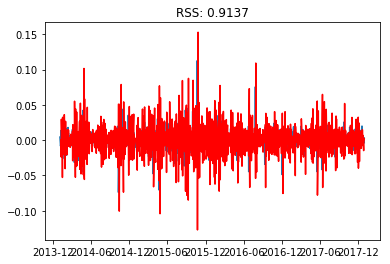

2 2 1


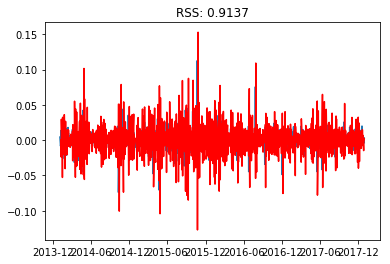

2 2 2


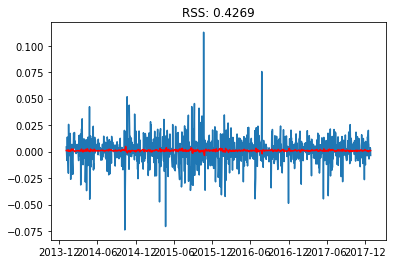

3 0 0


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.426438327514


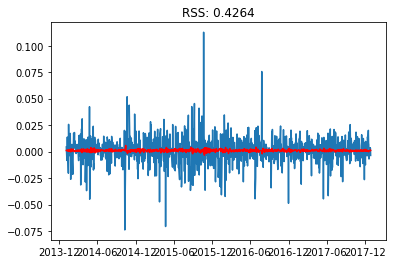

3 0 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.426419716718


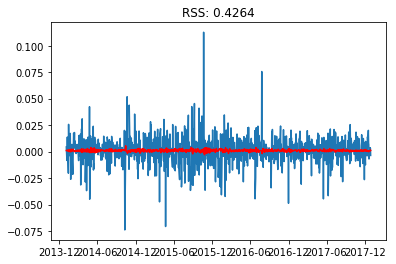

3 0 2


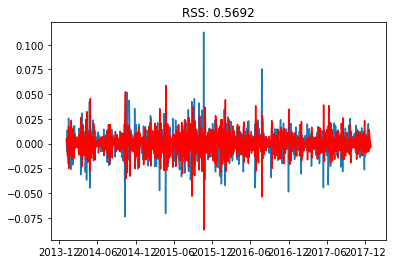

3 1 0


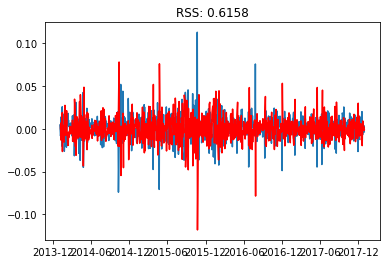

3 1 1


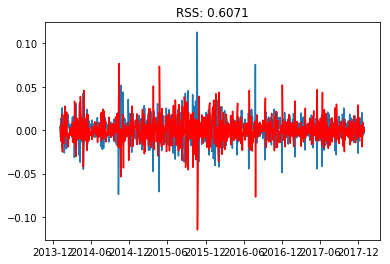

3 1 2


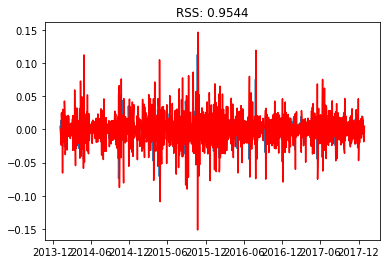

3 2 0


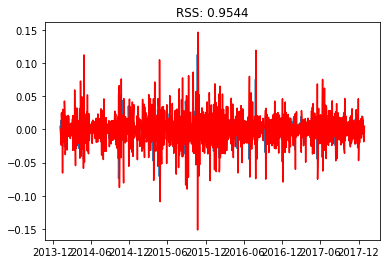

3 2 1


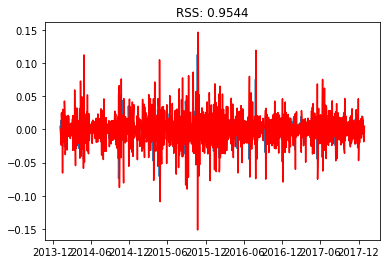

3 2 2


In [35]:
# do a brute force searc for parameters and find the best ones.

txn = txn.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff_txn.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff_txn)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff_txn)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

### Average ARIMA(p, d, q) 
After the brute force search for parameters test after differencing, it shows that the best average ARIMA order is (p = 3, d = 0, q = 0) with a lower value of RSS =0.4269. Because, the two model orders show the highest bleu area of point forecasts and a small area of red straight line for the most ARIMA fited values. 

512.989575816


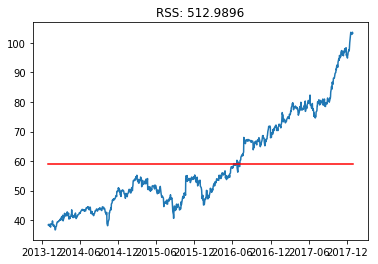

0 0 0
267.175553337


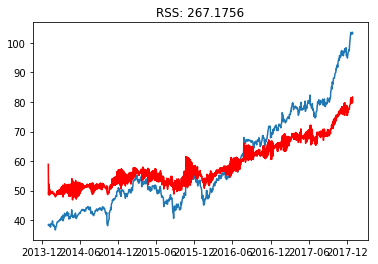

0 0 1
157.630637442


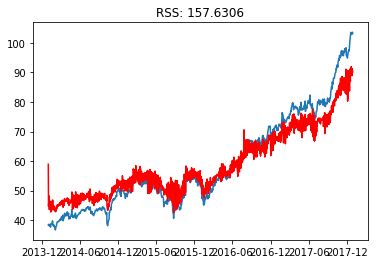

0 0 2


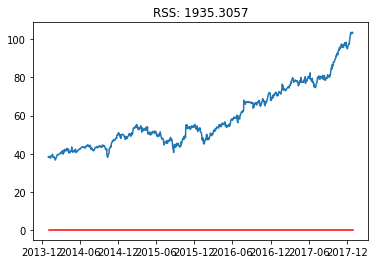

0 1 0


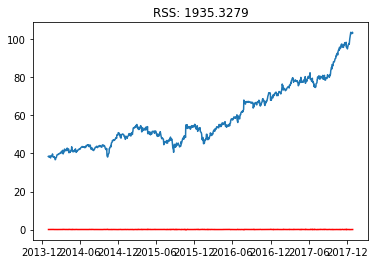

0 1 1


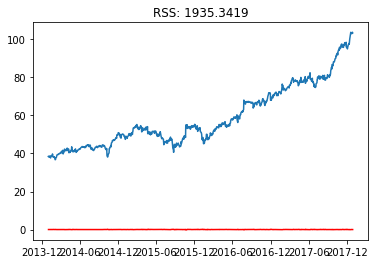

0 1 2


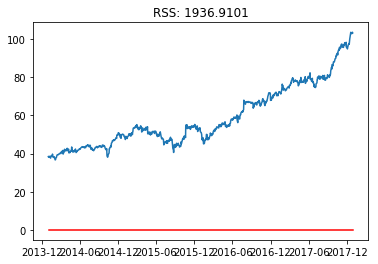

0 2 0


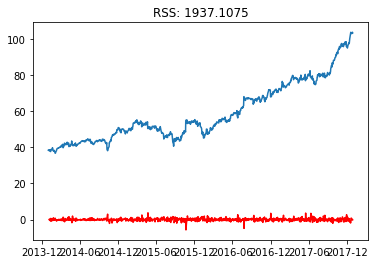

0 2 1


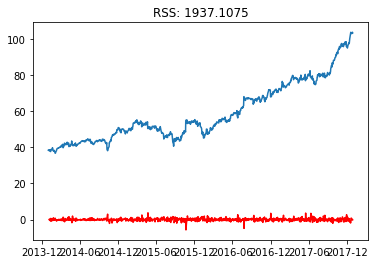

0 2 2
39.0103894174


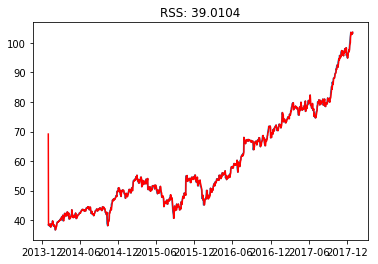

1 0 0


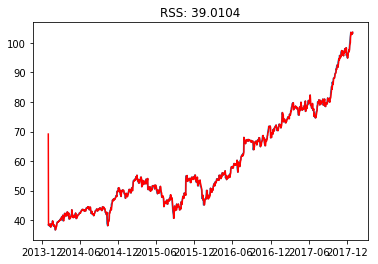

1 0 1


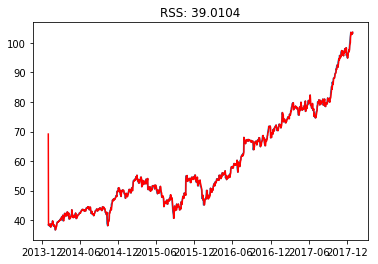

1 0 2


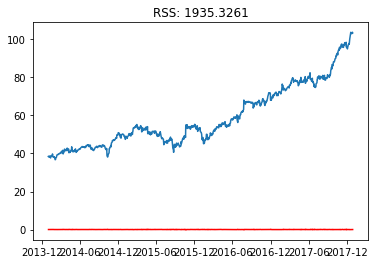

1 1 0


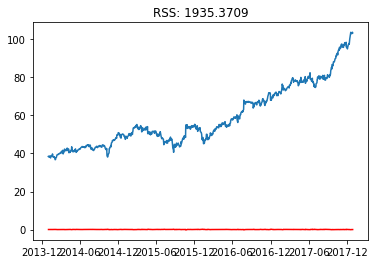

1 1 1


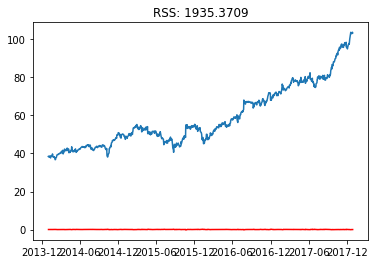

1 1 2


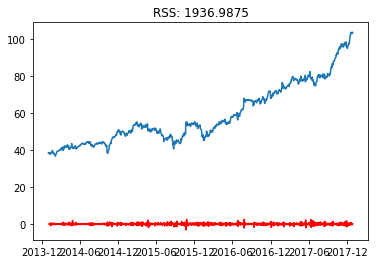

1 2 0


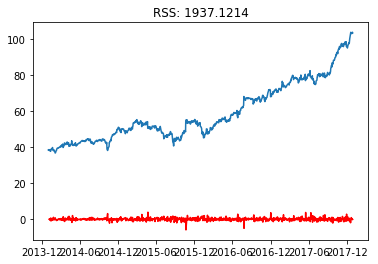

1 2 1


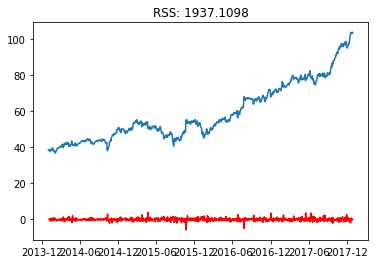

1 2 2


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32.0914683656


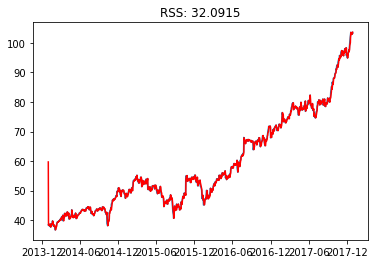

2 0 0


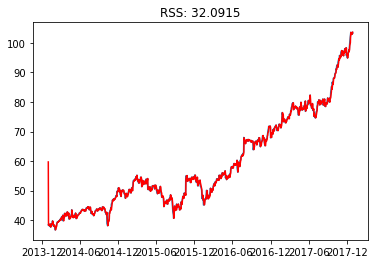

2 0 1


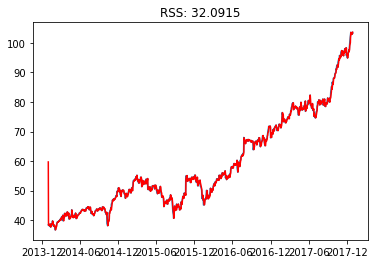

2 0 2


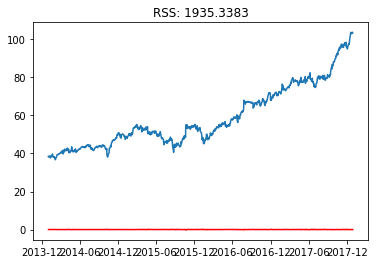

2 1 0


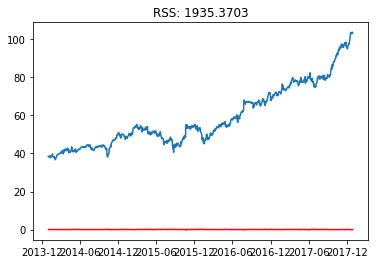

2 1 1


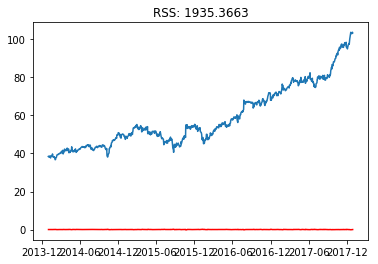

2 1 2


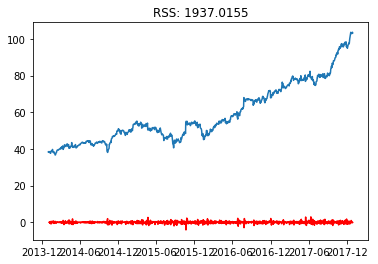

2 2 0


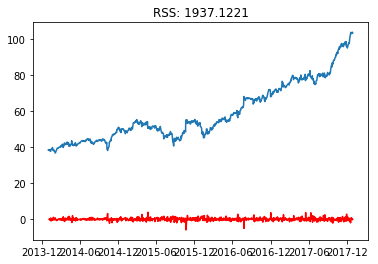

2 2 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:654: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


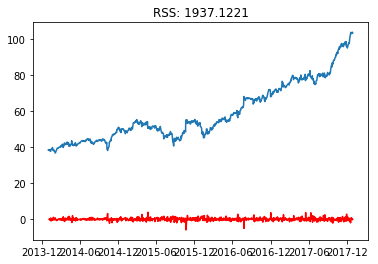

2 2 2
32.0702320493


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


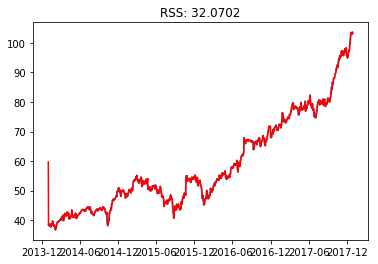

3 0 0


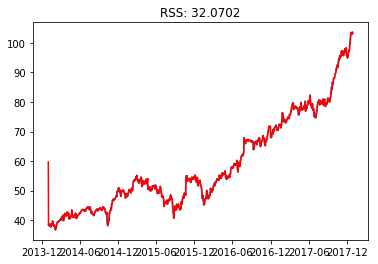

3 0 1


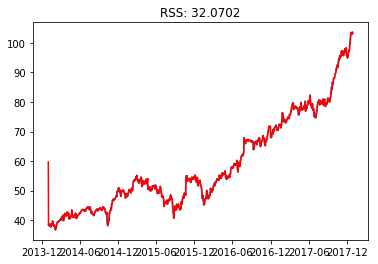

3 0 2


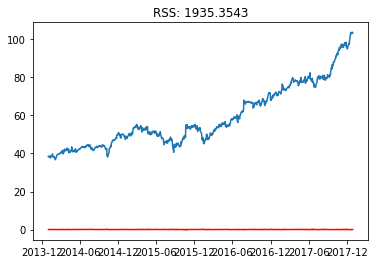

3 1 0


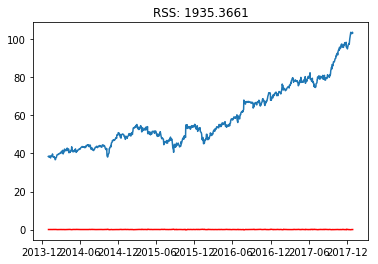

3 1 1


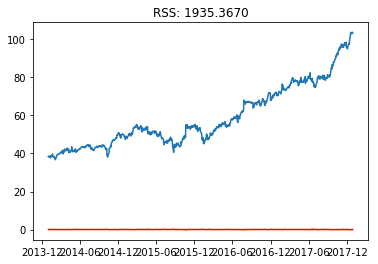

3 1 2


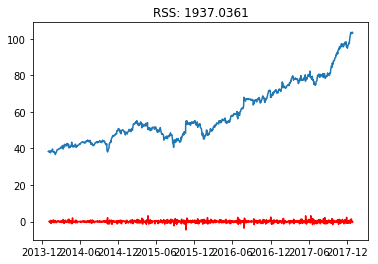

3 2 0


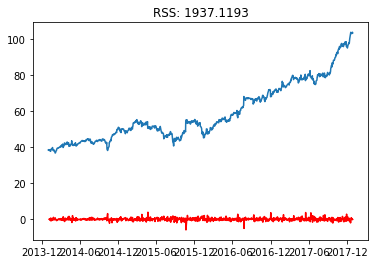

3 2 1


C:\Users\Deer\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


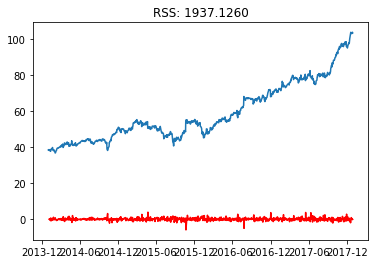

3 2 2


In [36]:
txn = txn.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(txn.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(txn)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(txn)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [37]:
print(loss_best)
print(best_ints)


32.0702320493
[3, 0, 0]


The Final test proves that the best model ARIMA order is (p=3, d=0, q=0) withe a best loss of 32.07023.
